In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Q1: Do smokers have higher insurance charges than non-smokers?

Null Hypothesis: There is no difference in insurance costs between smokers and non-smokers.

Alternative Hypothesis: There is a significant difference in insurance costs between smokers and non smokers.

Alpha = 0.05

T-Test

In [3]:
no_smoker = df.loc[ df['smoker']=='no',"charges"]
smoker = df.loc[ df['smoker']=='yes',"charges"]
## Getting means 
print(f"For smokers (n={len(smoker)}): Mean={np.mean(smoker):.2f}")
print(f"For not smoker (n={len(no_smoker)}): Mean={np.mean(no_smoker):.2f}")

For smokers (n=274): Mean=32050.23
For not smoker (n=1064): Mean=8434.27


In [4]:
zscores= stats.zscore(smoker)
outliers = abs(zscores)>3
print(f'Smokers: {np.sum(outliers)}')
zscores= stats.zscore(no_smoker)
outliers = abs(zscores)>3
print(f'Not Smokers: {np.sum(outliers)}')

Smokers: 0
Not Smokers: 24


In [5]:
# remove outliers from not smokers
no_smoker = no_smoker[(np.abs(stats.zscore(no_smoker)) < 3)]

In [6]:
# test the smoker group for normality
result_smoker_rate = stats.normaltest(smoker)
result_smoker_rate

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [7]:
result_non_smoker_rate = stats.normaltest(no_smoker)
result_non_smoker_rate

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [8]:
# Test for equal variance
result = stats.levene(smoker, no_smoker)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

In [9]:
# Final t-test, after confirming we meet the assumptions
result = stats.ttest_ind(no_smoker, smoker, equal_var = False )
result

Ttest_indResult(statistic=-33.732305987092516, pvalue=2.5753226625873578e-104)

The p-value is less than our alpha value, so we will reject the null hypothesis, and accept the alternate hypothesis

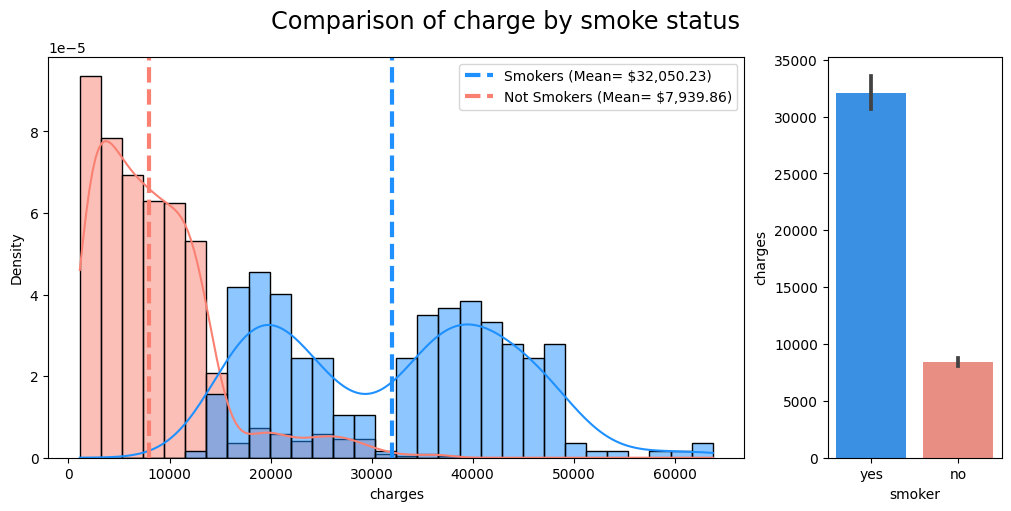

In [10]:
palette={'yes':'dodgerblue', 'no':'salmon'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=palette)

ax.axvline(np.mean(smoker), ls='--',lw=3, 
           label=f"Smokers (Mean= ${np.mean(smoker):,.2f})",color=palette['yes'])

ax.axvline(np.mean(no_smoker), ls='--', lw=3, 
           label=f"Not Smokers (Mean= ${np.mean(no_smoker):,.2f})",color=palette['no'])

ax.legend(prop={"size":10}, loc='upper right')

## Barplot

sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar,palette=palette)
fig.suptitle('Comparison of charge by smoke status',fontsize='xx-large');

Q2: Are men more likely to smoke than women?

Null: Men and Women smoke at the same rate

Alternative: Smoking rates differ between men and women

Chi-Test

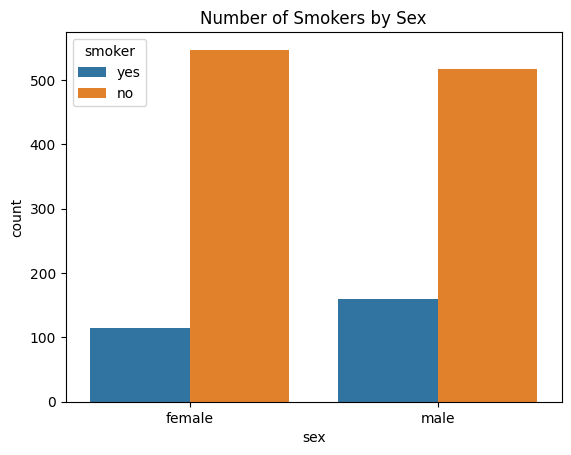

In [11]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

In [12]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [13]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result 

print(p>0.05)

False


We will reject the null hypothesis and accept the alternate as there is a significant difference gender and smoking.  

Q3: Do different regions have different charges, on average?

Null: There is no difference in insurance charges across regions.

Alternative: There is a difference in insurance charges among the regions.

Alpha = 0.05

ANOVA

In [14]:
#see how many data entries per region
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [15]:
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [16]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [17]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [18]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [19]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

In [20]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['charges']
labels = df['region']

In [22]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


The only significant difference is between southwest and southeast according to the turkey test